In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from utilities import *
data_dir="/Volumes/LaCie/savepred2"
img_dir=os.path.join(data_dir, "original")
gt_dir=os.path.join(data_dir, "ground_truth")
pred_dir=os.path.join(data_dir, "pred")

(3, 512, 512) (3, 512, 512) (3, 512, 512)


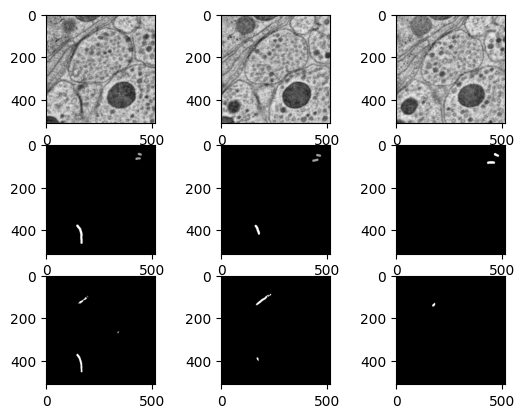

In [3]:
# 8144
# 9168
dim=512
z,y,x = 0,2512,2512
suffix = r"z{}_y{}_x{}".format(z, y, x)
img_vol = np.load(os.path.join(img_dir, f"{suffix}.npy"))
gt_vol = np.load(os.path.join(gt_dir, f"{suffix}.npy"))
pred_vol = np.load(os.path.join(pred_dir, f"{suffix}.npy"))
pred_vol = np.argmax(pred_vol[0], 0) 
print(img_vol.shape, gt_vol.shape, pred_vol.shape)
depth = pred_vol.shape[0]
fig, ax = plt.subplots(3,depth)
visualize_3d_slice(img_vol, ax[0])
visualize_3d_slice(gt_vol, ax[1])
visualize_3d_slice(pred_vol, ax[2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512, 3)


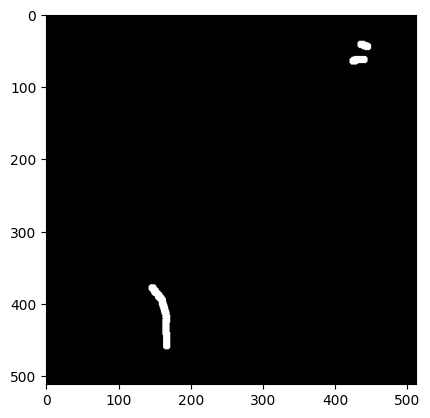

In [4]:
colored_gt = np.stack((gt_vol[0],)*3, axis=-1)
print(colored_gt.shape)
plt.imshow(colored_gt)

In [58]:
import copy
def assemble_predictions(images_dir, preds_dir, gt_dir, overlay=True):
    # superimpose the predictions on the image 
    red = (0, 0, 255) # FP
    green = (0, 255, 0) #TP
    blue = (255, 0, 0) #FN

    preds_colors = [green, red, blue]

    # magenta:
    # magenta = (255, 0, 255) #conf 5
    # cyan = (255, 255, 0) #conf 4
    # brown = (0, 255, 255) #conf 3
    # orange = (0, 165, 255) #conf 2
    # light_blue = (255, 165, 0) #conf 1
    conf5 = (255, 0, 255) #conf 5
    conf4 = (255, 255, 0) #conf 4
    conf3 = (0, 255, 255) #conf 3
    conf2 = (0, 165, 255) #conf 2
    conf1 = (255, 165, 0) #conf 1

    gt_colors = [conf1, conf2, conf3, conf4, conf5]
    for s in range(0, 3, 3):
        s_acc_img, s_acc_pred, s_acc_gt = [], [], []
        for y in tqdm(range(2000, 3024, 512)):
            y_acc_img, y_acc_pred, y_acc_gt = [], [], []
            for x in range(2000, 3024, 512):
                suffix = r"z{}_y{}_x{}".format(s, y, x)
                img_vol = np.load(os.path.join(images_dir, f"{suffix}.npy"))
                gt_vol = np.load(os.path.join(gt_dir, f"{suffix}.npy"))
                pred_vol = np.load(os.path.join(preds_dir, f"{suffix}.npy"))
                pred_vol = np.argmax(pred_vol[0], 0) 
                for k in range(3):
                    img = img_vol[k]
                    gt = gt_vol[k]
                    pred = pred_vol[k]
                    
                    # color the borders yellow
                    # img[0:2, :] = [0, 255, 255]
                    # img[-1:-3, :] = [0, 255, 255]
                    # img[:, 0:2] = [0, 255, 255]
                    # img[:, -1:-3] = [0, 255, 255]
                    y_acc_img += [img]

                    cond = np.logical_and(gt == 2, gt == 15)
                    masked_gt = copy.deepcopy(gt)
                    masked_gt[cond] = 0
                    masked_gt[masked_gt != 0] = 255
                    colored_gt = np.stack((gt,)*3, axis=-1)
                    colored_gt[gt == 3] = conf1
                    colored_gt[gt == 5] = conf2
                    colored_gt[gt == 7] = conf3
                    colored_gt[gt == 9] = conf4
                    colored_gt[gt == 11] = conf5

                    # color borders:
                    # colored_gt[0:2, :] = [0, 255, 255]
                    # colored_gt[-1:-3, :] = [0, 255, 255]
                    # colored_gt[:, 0:2] = [0, 255, 255]
                    # colored_gt[:, -1:-3] = [0, 255, 255]
                    y_acc_gt += [colored_gt]

                    # make preds color
                    pred_c= np.repeat(pred[:, :, np.newaxis], 3, axis=-1)
                    for m in range(3):
                        pred_c[(pred == 255) & (masked_gt == 255)] = green
                        pred_c[np.logical_and(pred == 255, masked_gt == 0)] = red
                        pred_c[np.logical_and(pred == 0, masked_gt == 255)] = blue
                    pred = pred_c
                    # pred[0:2, :] = [0, 255, 255]
                    # pred[-1:-3, :] = [0, 255, 255]
                    # pred[:, 0:2] = [0, 255, 255]
                    # pred[:, -1:-3] = [0, 255, 255]
                    y_acc_pred += [pred]

            s_acc_img += [np.concatenate(y_acc_img, axis=1)]
            s_acc_pred += [np.concatenate(y_acc_pred, axis=1)]
            s_acc_gt += [np.concatenate(y_acc_gt, axis=1)]

        new_img = np.concatenate(s_acc_img, axis=0)
        new_pred = np.concatenate(s_acc_pred, axis=0)
        new_gt = np.concatenate(s_acc_gt, axis=0)

        def write_legend(text, color, img, org):
            # font 
            font = cv2.FONT_HERSHEY_SIMPLEX 

            
            # fontScale 
            fontScale = 10
            
            # Line thickness of 2 px 
            thickness = 20

            return cv2.putText(img, text, org, font,  
                    fontScale, color, thickness, cv2.LINE_AA) 
        

        #write them all in
        save_dir = "/Volumes/LaCie/gapjnc10/"
        save_dir += "SEM_dauer_2_image_export_" + suffix + "/"
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        if overlay:
            new_pred = cv2.addWeighted(new_img, 0.5, new_pred, 0.1, 0)
            new_gt = cv2.addWeighted(new_img, 0.5, new_gt, 0.1, 0)

        for color in gt_colors:
            new_gt = write_legend(f"Confidence {gt_colors.index(color)}", color, new_gt, (450, 450+250*gt_colors.index(color)))

        for color in preds_colors:
            new_pred = write_legend(f"{['TP', 'FP', 'FN'][preds_colors.index(color)]}", color, new_pred, (450, 450+250*preds_colors.index(color)))

        if not os.path.isdir(save_dir):
            os.mkdir(save_dir)
        assert cv2.imwrite(save_dir + "SEM_dauer_2_image_export_" + suffix + "_img.png", new_img)
        assert cv2.imwrite(save_dir + "SEM_dauer_2_image_export_" + suffix + "_pred.png", new_pred)
        assert cv2.imwrite(save_dir + "SEM_dauer_2_image_export_" + suffix + "_gt.png", new_gt)

In [59]:
from tqdm import tqdm 
assemble_predictions(img_dir, pred_dir, gt_dir)

100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/core/src/arithm.cpp:650: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'
